<a href="https://colab.research.google.com/github/dmytro-varich/Texture-Segmentation-App/blob/main/segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Jacob Gildenblat, 2015
#Implementation of edge preserving smoothing by minimizing with the Ambrosio-Tortorelli appoach
#AM scheme, using conjugate gradients
import cv2, scipy
import numpy as np
import sys
import scipy
from scipy.sparse.linalg import LinearOperator

class AmbrosioTortorelliMinimizer():
	def __init__(self, img, iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01):
		self.iterations = iterations
		self.tol = tol
		self.g = np.float64(img) / np.max(img)
		self.f = self.g
		self.edges = np.zeros(img.shape)
		self.update_gradients()
		self.alpha, self.beta, self.epsilon = alpha, beta, epsilon
		self.add_const = self.beta / (4 * self.epsilon)
		self.multiply_const = self.epsilon * self.beta
		self.maxiter = solver_maxiterations

	def update_gradients(self):
		self.grad_x, self.grad_y = self.gradients(self.f)
		self.gradient_mag = np.power(self.grad_x, 2) + np.power(self.grad_y, 2)

	def edge_linear_operator(self, input):
		v = input.reshape(*self.g.shape)
		result = np.multiply(v, self.gradient_mag * self.alpha + self.add_const) \
				- self.multiply_const* cv2.Laplacian(v, cv2.CV_64F)

		return result.reshape(*input.shape)

	def image_linear_operator(self, input):
		f = input.reshape(*self.g.shape)

		x, y = self.gradients(f)

		result = f - 2*self.alpha * (self.calc_grad_x(np.multiply(self.edges, x)) + self.calc_grad_y(np.multiply(self.edges, y)) )
		return result.reshape(*input.shape)

	def solve_edges(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.edge_linear_operator, dtype = np.float64)
		b = np.ones(size) * self.beta / (4 * self.epsilon)

		self.edges, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.edges = np.power(self.edges.reshape(*self.g.shape), 2)
		return self.edges

	def solve_image(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.image_linear_operator, dtype = np.float64)
		b = self.g.reshape(size)

		self.f, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.f = self.f.reshape(*self.g.shape)
		self.update_gradients()
		return self.f

	def minimize(self):
		for i in range(0, self.iterations):
			self.solve_edges()
			self.solve_image()

		self.edges = np.power(self.edges, 0.5)
		cv2.normalize(self.f, self.f ,0,255,cv2.NORM_MINMAX)
		cv2.normalize(self.edges, self.edges ,0,255,cv2.NORM_MINMAX)
		self.f = np.uint8(self.f)
		self.edges = 255 - np.uint8(self.edges)

		return self.f, self.edges

	def calc_grad_x(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]))

	def calc_grad_y(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]).T)

	def gradients(self, img):
		return self.calc_grad_x(img), self.calc_grad_y(img)

In [2]:
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-wlnji0c1
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-wlnji0c1
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405187 sha256=4e8be4e5db230627cad4eaf120d7f31d94927d84dfb40134e5e05af9b2c2632a
  Stored in directory: /tmp/pip-ephem-wheel-cache-dxc_upfs/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


In [16]:
# Standard libraries
import os
from typing import Union, Dict, Tuple, List, Any, Optional

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

# skimage libraries
from skimage import io
from skimage.filters.rank import entropy
from skimage.filters import gaussian

# sklearn libraries
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler

# pydensecrf library
import pydensecrf.densecrf as dcrf

In [4]:
class FileHandlerMixin:
    """
    A mixin class to provide functionality for loading and saving images.
    """
    @staticmethod
    def load_images(directory: str) -> Dict[str, np.ndarray]:
        """
        Load all images from the specified directory and return them as a dictionary.

        Parameters:
        -----------
        directory : str
            The path to the directory containing images.

        Returns:
        --------
        Dict[str, np.ndarray]
            A dictionary where keys are filenames and values are images.
        """
        images = dict()

        if not os.path.isdir(directory):
            raise ValueError(f"The specified directory '{directory}' does not exist or is not a valid directory.")

        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                try:
                    image = io.imread(file_path)
                    images[filename] = image
                except Exception as e:
                    print(f"Failed to read '{filename}': {e}")

        return images

    @staticmethod
    def save_segmented_images(directory: str, segmented_images: Dict[str, np.ndarray], tag: str = 'seg') -> None:
        """
        Save segmented images to a specified directory, modifying filenames with a given tag.

        Parameters:
        -----------
        directory : str
            The target directory to save the images.
        segmented_images : Dict[str, np.ndarray]
            A dictionary of filenames and segmented images.
        tag : str, optional, default 'seg'
            The tag to replace 'tg' in filenames.

        Returns:
        --------
        None
        """
        os.makedirs(directory, exist_ok=True)

        for filename, image in segmented_images.items():
            new_filename = filename.replace('tg', tag)
            file_path = os.path.join(directory, new_filename)

            try:
                imageio.imwrite(file_path, image)
            except Exception as e:
                print(f"Error saving image '{new_filename}': {e}")

In [29]:
class TextureSegmentation(FileHandlerMixin):
    """"""
    @staticmethod
    def show_images(
        images: Dict[str, np.ndarray],
        *,
        rows: int,
        cols: int,
        figsize: Tuple[int, int] = (15, 10),
        cmap: Optional[str],
        show_ax: str = 'on'
    ) -> None:
        """
        Displays a grid of images with titles on a subplot grid.

        Args:
            images (dict): A dictionary where keys are image titles and values are the images themselves.
            rows (int): Number of rows in the subplot grid.
            cols (int): Number of columns in the subplot grid.
            figsize (tuple): The size of the entire figure (width, height). Default is (15, 10).
            cmap (str): Colormap to be used for the images (optional).
            show_ax (str): Whether to display axis ('on' or 'off'). Default is 'on'.

        Returns:
            None
        """
        # Create a subplot grid with the specified number of rows and columns
        fig, axes = plt.subplots(rows, cols, figsize=figsize)

        # If there is only one axis (for example, when rows=1 and cols=1)
        if rows == 1 and cols == 1:
            axes = [axes]
        else:
          axes = axes.flatten()  # Flattening the axes to 1D array

        # Iterate over the axes and images to display them
        for ax, (title, image) in zip(axes, images.items()):
            # Create a copy of the image for normalization
            img = image * 1
            # Ensure img is a numpy array
            img = np.asarray(img)
            # Normalize the image to the range [0, 255]
            # Modified to handle float32 images with cv2.normalize
            if img.dtype == np.float32:  # Check if dtype is float32
                img = (img * 255).astype(np.uint8) # Scale to 0-255 and convert to uint8
            else:
                cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  # Existing code for other types
            # Convert the image to uint8 format for display
            img = np.uint8(img)
            # Display the image
            ax.imshow(img, cmap=cmap)
            # Set the title of the image
            ax.set_title(title)
            # Hide or show axes depending on 'show_ax' argument
            ax.axis(show_ax)

        # Adjust layout to make the plot elements fit neatly
        plt.tight_layout()

        # Display the plot
        try:
            plt.show()
        except KeyboardInterrupt:
            pass

    @staticmethod
    def preprocess_image(
        image: np.ndarray,
        *,
        resize_shape: Tuple[int, int] = None,
        normalize: bool = True,
        sigma: Optional[Union[float, int]],
        apply_edge_detection: bool = False
    ) -> np.ndarray:
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a NumPy array")

        # Resize the image if resize_shape is provided
        if resize_shape is not None:
            image = cv2.resize(image, resize_shape, interpolation=cv2.INTER_NEAREST)

        # Normalize image if required
        if normalize:
            image = image.astype(np.float32) / 255.0

        # Apply Gaussian blur if sigma is provided (None means no blur)
        if sigma is not None:
            blured = gaussian(image, sigma=sigma)
            #
            if apply_edge_detection:
                image = np.abs(image - blured)
            else:
                image = blured
        return image

    @staticmethod
    def extract_patches(image: np.ndarray, patch_size: Tuple[int, int] = (7, 7)) -> np.ndarray:
        # Extract patches
        try:
            # If patch_size is a tuple
            if isinstance(patch_size, tuple) and len(patch_size) == 2:
                patches: np.ndarray = extract_patches_2d(image, patch_size=patch_size)
            else:
                raise ValueError("patch_size must be an int or a tuple of length 2")
        except Exception as e:
            raise RuntimeError(f"Error extracting patches: {e}")

        return patches

    @staticmethod
    def find_optimal_clusters(data: np.ndarray, max_clusters: int = 50) -> int:
        # Initialize variables to track the best clustering configuration
        best_n = 0
        best_score = -1
        scores = []  # List to store silhouette scores for each number of clusters

        # Iterate over possible numbers of clusters
        for n_clusters in range(2, max_clusters + 1):
            # Perform clustering using MiniBatchKMeans
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(data)
            try:
                # Calculate silhouette score to evaluate clustering quality
                score = silhouette_score(data, labels)
            except Exception as e:
                print(f"Error calculating silhouette score for {n_clusters} clusters: {e}")
                continue

            # Store the silhouette score for this number of clusters
            scores.append(score)

            # If the current score is better than the previous best, update the best score and number of clusters
            if score > best_score:
                best_score = score
                best_n = n_clusters

        return best_n

    @staticmethod
    def cluster_patches(
        patches: Dict[str, np.ndarray],
        max_clusters: int = 50,
        *,
        n_components: Optional[int],
        find_optimal_clusters: Optional[bool]
    ) -> Tuple[np.ndarray, int]:
        # Combine all patches from the images into a single array
        all_patches = np.vstack([patch_list.reshape(patch_list.shape[0], -1)
                           for patch_list in patches.values()])

        # Normalize patches before PCA
        all_patches = (all_patches - np.mean(all_patches, axis=0)) / np.std(all_patches, axis=0)

        # Сохраняем PCA transformer для последующего использования
        global pca_transformer  # Делаем PCA доступным глобально

        # Apply PCA for dimensionality reduction if enabled
        if n_components is not None:
            pca_transformer  = PCA(n_components=n_components, whiten=True)
            reduced_patches = pca_transformer.fit_transform(all_patches)
        else:
            reduced_patches = all_patches
            pca_transformer = None

        # Determine the optimal number of clusters if enabled
        optimal_clusters = (TextureSegmentation.find_optimal_clusters(reduced_patches, max_clusters)
                            if find_optimal_clusters else max_clusters)

        # Perform K-Means clustering
        kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=42)
        kmeans.fit(reduced_patches)

        # Преобразуем центроиды обратно в оригинальное пространство
        if pca_transformer is not None:
            cluster_centroids = pca_transformer.inverse_transform(kmeans.cluster_centers_)
        else:
            # Cluster centroids = PRP (Principal Representative Patterns)
            cluster_centroids: np.ndarray = kmeans.cluster_centers_

        return cluster_centroids, optimal_clusters

    # def gaussian_similarity(patch: np.ndarray, prp: np.ndarray, sigma: float = 1.0, h: float = 1.0) -> float:
    #     patch = patch.reshape(-1)
    #     prp = prp.reshape(-1)
    #     # Euclidean distance
    #     distance = np.sum((patch - prp) ** 2)
    #     # Gaussian similarity
    #     weight = np.exp(-distance / (h**2 * sigma))
    #     return weight

    @staticmethod
    def compute_texture_features(
        image: np.ndarray,
        prp_centroids: np.ndarray,
        *,
        patch_size: Tuple[int, int] = (7, 7),
        gamma: float = 1.0  # This replaces sigma and h parameters
    ) -> np.ndarray:
        # Get image dimensions
        height, width = image.shape

        # Initialize array to store texture features
        texture_features = np.zeros((height, width))

        # Extract patches from the image
        patches = TextureSegmentation.extract_patches(image, patch_size)

        # Flatten the patches to vectors
        patch_vectors = patches.reshape(patches.shape[0], -1)
        print("PV1", patch_vectors)
        # Normalize patches using sklearn's MinMaxScaler
        # scaler = MinMaxScaler()
        # patch_vectors = scaler.fit_transform(patch_vectors)
        # print("PV2", patch_vectors)

        # Reshape PRP centroids
        prp_centroids = prp_centroids.reshape(prp_centroids.shape[0], -1)
        print("prp_centroids", patch_vectors)
        # Calculate offsets for patch centers
        offset_h = patch_size[0] // 2
        offset_w = patch_size[1] // 2

        # Compute RBF kernel between patches and PRP centroids
        similarities = rbf_kernel(patch_vectors, prp_centroids, gamma=gamma)
        print("similarities", similarities)
        # Normalize similarities
        sum_similarities = similarities.sum(axis=1, keepdims=True)
        probabilities = np.divide(similarities, sum_similarities,
                                where=sum_similarities > 0,
                                out=np.full_like(similarities, 1.0/similarities.shape[1]))

        # Get cluster assignments
        cluster_assignments = np.argmax(probabilities, axis=1)

        # Map the results back to the image dimensions
        for idx, cluster in enumerate(cluster_assignments):
            row = (idx // (width - patch_size[1] + 1)) + offset_h
            col = (idx % (width - patch_size[1] + 1)) + offset_w
            texture_features[row, col] = cluster

        return texture_features

    @staticmethod
    def segmentation(
        image: np.ndarray,
        prp_centroids: np.ndarray,
        *,
        patch_size: Tuple[int, int] = (7, 7),
        gamma: float = 1.0,
        iterations: int = 1,
        tol: float = 0.1,
        alpha: int = 1000,
        beta: float = 0.01,
        epsilon: float = 0.01
    ) -> Tuple[np.ndarray, np.ndarray]:
        # Compute texture features
        texture_map = TextureSegmentation.compute_texture_features(
            image, prp_centroids, patch_size=patch_size, gamma=gamma
        )

        # Mumford-Shah segmentation
        solver = AmbrosioTortorelliMinimizer(
            texture_map,
            iterations=iterations,
            tol=tol,
            alpha=alpha,
            beta=beta,
            epsilon=epsilon
        )
        segmented_image, edges = solver.minimize()

        return segmented_image, edges

    @staticmethod
    def assign_labels(
        segmented_image: np.ndarray,
        prp_centroids: np.ndarray,
        *,
        patch_size: Tuple[int, int] = (7, 7),
        sigma: float = 1.0
    ) -> np.ndarray:
        # Initialize array to store labels with the same shape as the segmented image
        labels = np.zeros_like(segmented_image)

        # Get image dimensions of the segmented image
        height, width = segmented_image.shape

        # Normalize the segmented image to the range [0, 1]
        segmented_image  = segmented_image.astype(np.float32) / 255.0

        # Extract patches from the image
        patches = TextureSegmentation.extract_patches(segmented_image, patch_size)

        # Flatten the patches to vectors
        patch_vectors = patches.reshape(patches.shape[0], -1)

        # Calculate offsets for patch centers
        offset_h = patch_size[0] // 2
        offset_w = patch_size[1] // 2

        # Iterate over each patch and compute texture features
        for idx, patch in enumerate(patch_vectors):
            # Calculate the row and column for the center of the patch
            row = (idx // (width  - patch_size[1] + 1)) + offset_h
            col = (idx % (width - patch_size[1] + 1)) + offset_w

            # Calculate similarity of the patch with each PRP centroid
            similarities = [
                TextureSegmentation.gaussian_similarity(patch, prp, sigma)
                for prp in prp_centroids
            ]

            # Assign the label corresponding to the PRP with the highest similarity
            labels[row, col] = np.argmax(similarities)

        return labels

    @staticmethod
    def postprocess_segmentation(segmented_image, edges, labels, *, num_classes, sxy=3, srgb=3, iter_max=5) -> np.ndarray:
        # Подготовка изображения
        image = segmented_image.astype(np.uint8)  # Используем segmented_image

        # Преобразование изображения в формат CRF (объединение цветовых каналов)
        unary = np.zeros((image.shape[0] * image.shape[1], num_classes), dtype=np.float32)

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                label = labels[i, j]
                unary[i * image.shape[1] + j, int(label)] = 1  # Convert label to int

        # Reshape to (H, W, num_classes) before taking -np.log
        unary = unary.reshape((image.shape[0], image.shape[1], num_classes))
        unary = -np.log(np.clip(unary, 1e-10, None))  # Apply log transformation

        # Reshape to (num_classes, H * W)
        unary = unary.transpose(2, 0, 1).reshape(num_classes, -1)

        # Создание CRF модели
        d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], num_classes)

        # Добавление функции потерь: unary (изначальные вероятности принадлежности к классу)
        unary = np.ascontiguousarray(unary)  # Ensure contiguous memory layout
        d.setUnaryEnergy(unary)

        # Добавление пары пикселей (цветовое сходство)
        d.addPairwiseGaussian(sxy=sxy, compat=10)

        # Добавление крекинга на краях (edges) — использование ваших границ для усиления/угнетения классов на границе
        if len(image.shape) == 2:
            image = np.repeat(image[:, :, np.newaxis], 3, axis=-1)
        d.addPairwiseBilateral(sxy=sxy, srgb=srgb, rgbim=image, compat=10, kernel=dcrf.DIAG_KERNEL)

        # Оптимизация
        Q = d.inference(iter_max)
        result = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))  # Update: Get argmax

        return result

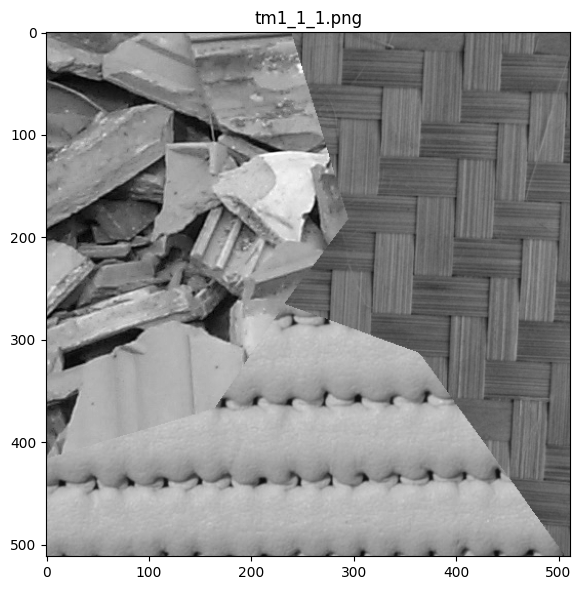

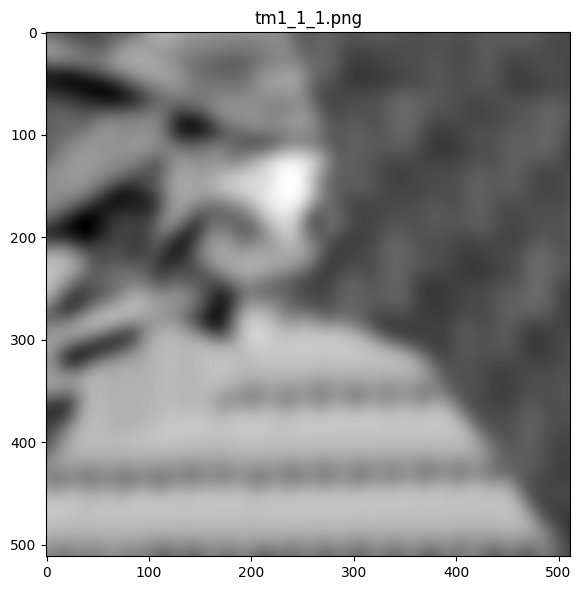

{'tm1_1_1.png': array([[[0.4821934 , 0.479776  , 0.4772281 , ..., 0.47177657,
         0.46889228, 0.46591586],
        [0.48866922, 0.48618454, 0.48356196, ..., 0.47793925,
         0.47495914, 0.47188088],
        [0.4954787 , 0.4929343 , 0.4902446 , ..., 0.4844656 ,
         0.4813969 , 0.47822368],
        ...,
        [0.509869  , 0.50723654, 0.5044448 , ..., 0.49841857,
         0.49520493, 0.4918733 ],
        [0.5173062 , 0.51465017, 0.5118284 , ..., 0.5057217 ,
         0.5024572 , 0.4990678 ],
        [0.5247915 , 0.52212846, 0.51929396, ..., 0.5131422 ,
         0.509845  , 0.50641584]],

       [[0.479776  , 0.4772281 , 0.47455847, ..., 0.46889228,
         0.46591586, 0.46285826],
        [0.48618454, 0.48356196, 0.48081028, ..., 0.47495914,
         0.47188088, 0.4687161 ],
        [0.4929343 , 0.4902446 , 0.48741838, ..., 0.4813969 ,
         0.47822368, 0.47495815],
        ...,
        [0.50723654, 0.5044448 , 0.50150216, ..., 0.49520493,
         0.4918733 , 0.4884368

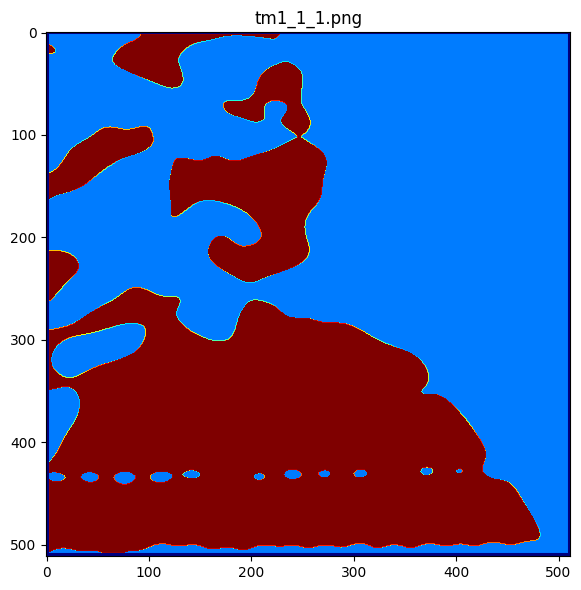

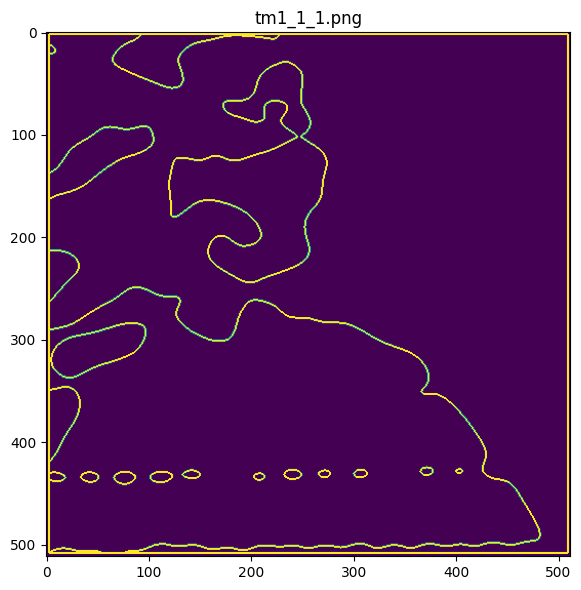

In [30]:
def main(directory):
    # Load images from the specified directory
    images: dict = TextureSegmentation.load_images(directory)

    # Display the images
    rows, cols, figsize = 1, 1, (8, 6)
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Preprocess images
    resize_shape = None
    normalize = True
    sigma = 10.0
    apply_edge_detection = False
    for key, image in images.items():
        images[key] = TextureSegmentation.preprocess_image(image,
                                                           resize_shape=resize_shape,
                                                           normalize=normalize,
                                                           sigma=sigma,
                                                           apply_edge_detection=apply_edge_detection)

    # Display the preprocessed images
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Extract patches from the preprocessed images
    patches = dict()
    patch_size = (7, 7)
    for key, image in images.items():
        patches[key] = TextureSegmentation.extract_patches(image, patch_size=patch_size)
    print(patches)
    # Cluster patches to find PRP (Principal Representative Patterns)
    max_clusters = 5
    n_components = None
    prp_centroids, optimal_clusters = TextureSegmentation.cluster_patches(patches,
                                                                    max_clusters=max_clusters,
                                                                    n_components=n_components,
                                                                    find_optimal_clusters=False)
    print(prp_centroids)
    # Segment the images by extracting texture features and using the Mumford-Shah
    segmented_images, edges = dict(), dict()
    gamma = 0.4
    iterations, alpha, beta, epsilon  = 1, 1000, 0.01, 0.01
    for key, image in images.items():
        segmented_images[key], edges[key] = TextureSegmentation.segmentation(image, prp_centroids,
                                                                            patch_size=patch_size,
                                                                            gamma=gamma,
                                                                            iterations=iterations,
                                                                            alpha=alpha, beta=beta,
                                                                             epsilon=epsilon)
    # Display the segmented images and edges
    TextureSegmentation.show_images(segmented_images, figsize=figsize, rows=rows, cols=cols, cmap='jet')
    TextureSegmentation.show_images(edges, figsize=figsize, rows=rows, cols=cols, cmap=None)

    # # Assign labels to the segmented images
    # labels = dict()
    # for key, segmented_image in segmented_images.items():
    #     labels[key] = TextureSegmentation.assign_labels(segmented_image, prp_centroids,
    #                                                     patch_size=patch_size,
    #                                                     sigma=sigma)

    # # Display the labels
    # TextureSegmentation.show_images(labels, figsize=figsize, rows=rows, cols=cols, cmap='tab20')

    # # Postprocess images using CRF
    # postprocessed_images = dict()
    # for key, segmented_image in segmented_images.items():
    #     postprocessed_images[key] = TextureSegmentation.postprocess_segmentation(segmented_image, edges[key], labels[key],
    #                                                                              num_classes=optimal_clusters)

    # # Display the postprocessed images
    # TextureSegmentation.show_images(postprocessed_images, figsize=figsize, rows=rows, cols=cols, cmap='tab20')

    # Save the segmented images to the output directory
    # TextureSegmantation.save_segmented_images('output', {})

if __name__ == '__main__':
    directory = 'data/'
    main(directory)